In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from train import soft_net, relu_net

In [2]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

In [3]:
device = "cpu"

In [81]:
pretrained_relu = "mnist_cnn_relu.pt"
relu_model = relu_net().to(device)
relu_model.load_state_dict(torch.load(pretrained_relu, map_location='cpu'))
relu_model.eval()
pretrained_soft = "mnist_cnn_soft_tau=1.pt"
soft_model = soft_net(1).to(device)
soft_model.load_state_dict(torch.load(pretrained_soft, map_location='cpu'))
soft_model.eval()

soft_net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [82]:
# Define forward hook for activation sparsity
sparsities = {"relu": {},
              "soft": {}
              }

def get_hook( model_name, layer_name ):
    def sparsity( model, input, output ):
        non_zero = torch.count_nonzero( input[0] ) / torch.numel( input[ 0 ])
        if sparsities.get(model_name).get( layer_name, None ) is not None: 
            sparsities[model_name][ layer_name ] += non_zero
        else: 
            sparsities[model_name][ layer_name ] = non_zero 
    
    return( sparsity )


In [83]:
soft_model.conv1.register_forward_hook( get_hook( "soft", "inputs") )
soft_model.conv2.register_forward_hook( get_hook( "soft", "conv1") )
soft_model.fc1.register_forward_hook( get_hook( "soft","conv2") )
soft_model.fc2.register_forward_hook( get_hook( "soft", "fc1") )

In [84]:
relu_model.conv1.register_forward_hook( get_hook( "relu", "inputs") )
relu_model.conv2.register_forward_hook( get_hook( "relu", "conv1") )
relu_model.fc1.register_forward_hook( get_hook( "relu","conv2") )
relu_model.fc2.register_forward_hook( get_hook( "relu", "fc1") )

In [85]:
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    soft_model( data )
    relu_model( data )

In [86]:
sparsities

{'relu': {'inputs': tensor(10000.),
  'conv1': tensor(5035.4761),
  'conv2': tensor(529.0568),
  'fc1': tensor(2238.3359)},
 'soft': {'inputs': tensor(10000.),
  'conv1': tensor(5734.6157),
  'conv2': tensor(3977.8779),
  'fc1': tensor(9322.0625)}}

In [87]:
average_soft = [ value / len( test_loader ) for value in sparsities[ "soft"].values() ] 
average_relu = [ value / len( test_loader ) for value in sparsities[ "relu"].values() ] 

Text(0.5, 1.0, 'Activation sparsities in the hidden layers')

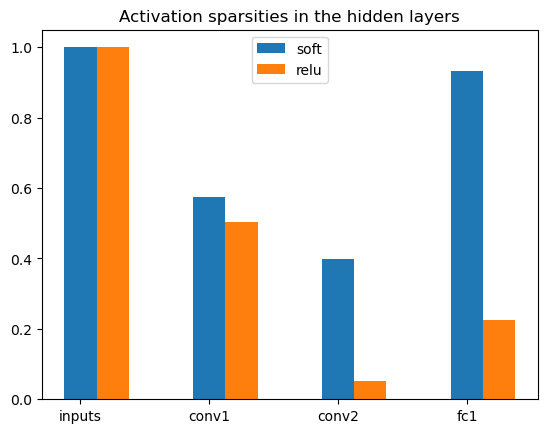

In [88]:
width = 0.25
labels = [ "inputs", "conv1", "conv2", "fc1" ]
x = np.arange( len(sparsities[ "soft"].values() ))
fig, ax = plt.subplots(1)
ax.bar( labels, average_soft , width=width, label = "soft")
ax.bar( x+width, average_relu, width=width, label = "relu")
ax.legend()
plt.title( "Activation sparsities in the hidden layers")